### Cut VQE Circuits for Varying Ansatzes, Display Cut Circuits, and Compare Energy with Regular VQE

In [2]:
from qiskit.primitives import Estimator
from qiskit.quantum_info import SparsePauliOp
from qiskit_algorithms.minimum_eigensolvers import VQE
from qiskit_algorithms.optimizers import COBYLA

from circuit_knitting.cutting.gate_and_wire_cutting.algorithms.cut_vqe import CutVQE

/usr/lib/python3/dist-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 1.1build1 is an invalid version and will not be supported in a future release
  warnings.warn(


### 1. Problem Setup

#### Basis Set Choice:
* sto3g, sto6g - 4 qubits
* **321g, 631g - 8 qubits** 
* 6311g - 12 qubits
* cc-pvdz, def2-SVP - 20 qubits
* aug-cc-pVDZ - 36 qubits

In [3]:
from qiskit_nature.units import DistanceUnit
from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit_nature.second_q.mappers import ParityMapper, JordanWignerMapper, BravyiKitaevMapper

# Use PySCF to get the hamiltonian operator list from the molecular geometry
driver = PySCFDriver(
    atom='H .0 .0 .0; H .0 .0 0.735',
    unit=DistanceUnit.ANGSTROM,
    basis='631g',
)
problem = driver.run()

# setup the qubit mapper
mapper = JordanWignerMapper()

hamiltonian = problem.hamiltonian.second_q_op()
qubit_op = mapper.map(hamiltonian)

H2_op_list = []
for pauli, coeff in sorted(qubit_op.label_iter()):
    #print(f"{coeff.real:+.8f} * {pauli}")
    H2_op_list.append((pauli, float(coeff.real)))

Get the Hamiltonian operator:

In [4]:
H2_op = SparsePauliOp.from_list(H2_op_list)
H2_op.num_qubits

8

### 2. Create Ansatz and Cut (PauliTwoDesign)

Create the ansatz from Qiskit objects and display it:

OrderedDict([('r', 20), ('h', 14), ('cx', 7), ('u1', 4), ('barrier', 2)])
8


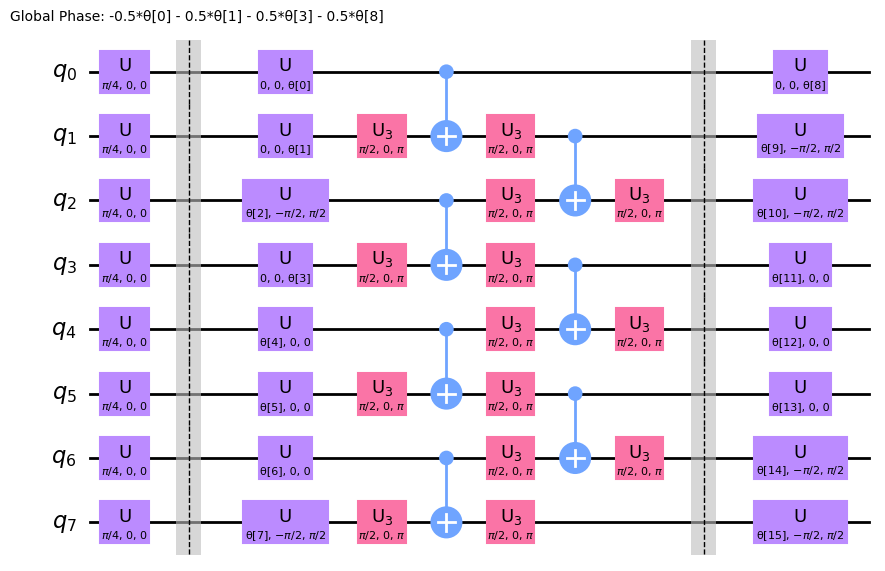

In [24]:
from qiskit.circuit.library import TwoLocal, EfficientSU2, RealAmplitudes, PauliTwoDesign, ExcitationPreserving

ansatz = PauliTwoDesign(H2_op.num_qubits, reps=1, seed=5, insert_barriers=True)
ansatz = ansatz.decompose(reps=2)
 
print(ansatz.count_ops())
print(ansatz.depth())
ansatz.decompose(reps=2).draw('mpl')

Visualize the subcircuits:

In [25]:
circuit = ansatz.decompose(reps=3)

# See how many parameters are in our ansatz
num_params = circuit.num_parameters
print(f'Num parameters: {num_params}')

# List out the observables
observables_paulis = H2_op.paulis
observables = [str(i) for i in observables_paulis]
print(f'Observables: {observables}')

Num parameters: 16
Observables: ['IIIIIIII', 'IIIIIIIZ', 'IIIIIIZI', 'IIIIIIZZ', 'IIIIIXIX', 'IIIIIXZX', 'IIIIIYIY', 'IIIIIYZY', 'IIIIIZII', 'IIIIIZIZ', 'IIIIIZZI', 'IIIIXIXI', 'IIIIXXXX', 'IIIIXXYY', 'IIIIXYYX', 'IIIIXZXI', 'IIIIXZXZ', 'IIIIYIYI', 'IIIIYXXY', 'IIIIYYXX', 'IIIIYYYY', 'IIIIYZYI', 'IIIIYZYZ', 'IIIIZIII', 'IIIIZIIZ', 'IIIIZIZI', 'IIIIZXZX', 'IIIIZYZY', 'IIIIZZII', 'IIIZIIII', 'IIIZIIIZ', 'IIIZIIZI', 'IIIZIXZX', 'IIIZIYZY', 'IIIZIZII', 'IIIZXZXI', 'IIIZYZYI', 'IIIZZIII', 'IIXXIIXX', 'IIXXIIYY', 'IIXXIXXI', 'IIXXIYYI', 'IIXXXXII', 'IIXXXZZX', 'IIXXYYII', 'IIXXYZZY', 'IIYYIIXX', 'IIYYIIYY', 'IIYYIXXI', 'IIYYIYYI', 'IIYYXXII', 'IIYYXZZX', 'IIYYYYII', 'IIYYYZZY', 'IIZIIIII', 'IIZIIIIZ', 'IIZIIIZI', 'IIZIIXZX', 'IIZIIYZY', 'IIZIIZII', 'IIZIXZXI', 'IIZIYZYI', 'IIZIZIII', 'IIZZIIII', 'IXIXIIII', 'IXXIIIXX', 'IXXIIIYY', 'IXXIIXXI', 'IXXIIYYI', 'IXXIXXII', 'IXXIXZZX', 'IXXIYYII', 'IXXIYZZY', 'IXZXIIII', 'IXZXIIIZ', 'IXZXIIZI', 'IXZXIXZX', 'IXZXIYZY', 'IXZXIZII', 'IXZXXZXI', 'IXZXYZ

In [26]:
from circuit_knitting.cutting.gate_and_wire_cutting.frontend import cut_wires_and_gates_to_subcircuits

subcircuits, subobservables = cut_wires_and_gates_to_subcircuits(
    circuit=circuit,
    observables=observables,
    method='automatic',
    max_subcircuit_width=H2_op.num_qubits/2,
    max_cuts=4,
    num_subcircuits=[2],
    model='gurobi'
)

Set parameter TimeLimit to value 300
Set parameter Cutoff to value 1e+100
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (linux64)

CPU model: 11th Gen Intel(R) Core(TM) i7-11850H @ 2.50GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 175 rows, 93 columns and 530 nonzeros
Model fingerprint: 0x5ee7660b
Variable types: 0 continuous, 93 integer (70 binary)
Coefficient statistics:
  Matrix range     [1e-02, 2e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 2e+01]
  RHS range        [1e+00, 2e+00]
Presolve removed 44 rows and 35 columns
Presolve time: 0.00s
Presolved: 131 rows, 58 columns, 399 nonzeros
Variable types: 0 continuous, 58 integer (49 binary)
Found heuristic solution: objective 4.0000000
Found heuristic solution: objective 3.0000000
Found heuristic solution: objective 2.0000000

Root relaxation: objective 5.714286e-01, 53 iterations, 0.00 seconds (0.00 work units)


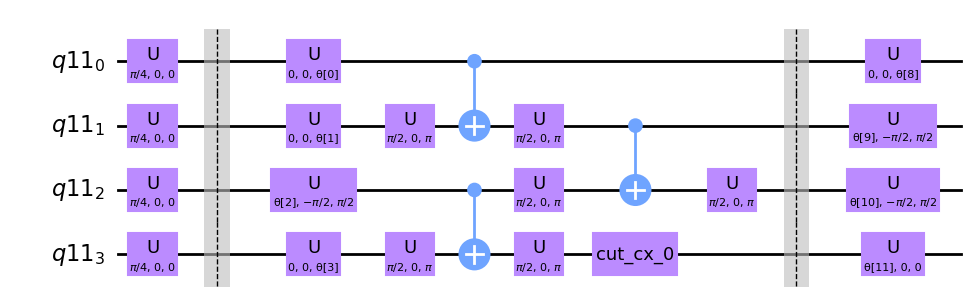

In [27]:
subcircuits[0].draw('mpl')

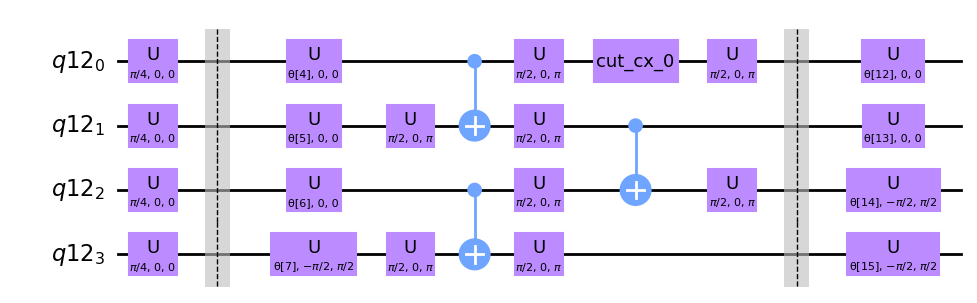

In [28]:
subcircuits[1].draw('mpl')

### 3. Get Energies for Cut Problem and Compare with Original (PauliTwoDesign)

In [29]:
# Create a callback function that will be used to get VQE data during the run 
def callback(eval_count, parameters, mean, std):
    print(f"Round num: {eval_count}, energy: {mean}, parameters: {parameters}")

In [30]:
# Use the modified CutVQE to cut and run VQE for our problem
estimator = Estimator()
optimizer = COBYLA(maxiter=80)
vqe = CutVQE(estimator, circuit, optimizer, observables=observables, shots=2**12, max_subcircuit_width=H2_op.num_qubits/2, max_cuts=9, num_subcircuits=[2], model='gurobi', num_samples=1500, callback=callback)
result = vqe.compute_minimum_eigenvalue(H2_op)
print(result)

Set parameter TimeLimit to value 300
Set parameter Cutoff to value 1e+100
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (linux64)

CPU model: 11th Gen Intel(R) Core(TM) i7-11850H @ 2.50GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 175 rows, 93 columns and 530 nonzeros
Model fingerprint: 0xdf137b61
Variable types: 0 continuous, 93 integer (70 binary)
Coefficient statistics:
  Matrix range     [1e-02, 2e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 3e+01]
  RHS range        [1e+00, 2e+00]
Presolve removed 44 rows and 35 columns
Presolve time: 0.00s
Presolved: 131 rows, 58 columns, 399 nonzeros
Variable types: 0 continuous, 58 integer (49 binary)
Found heuristic solution: objective 4.0000000

Root relaxation: objective 5.714286e-01, 53 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Ob

Round num: 27, energy: -0.37438086881251204, parameters: [ 0.55303348  2.07147238  0.13460796 -3.39291203  5.50704693 -2.49557139
 -5.2544762   0.08938153 -6.05108651  2.69248638 -0.26845586  2.24813562
  5.82174387 -2.70721087  6.58892517  3.85710704]
Round num: 28, energy: -0.30542407180965075, parameters: [ 0.54565278  2.12631198 -0.05034961 -3.41245342  5.59814589 -2.50868148
 -5.56821163 -0.06563658 -6.04735452  2.69862383 -0.24697827  2.38441652
  5.75647582 -1.90622328  6.79700691  3.50612111]
Round num: 29, energy: -0.3345143481801964, parameters: [ 0.55303348  2.07147238  0.13460796 -3.39291203  5.50704693 -2.49557139
 -5.2544762   0.08938153 -6.05108651  3.19106347 -0.24180169  2.22148144
  5.82174387 -2.70721087  6.58892517  3.85710704]
Round num: 30, energy: 0.1313390319950843, parameters: [ 0.55063195  2.08931605  0.07442659 -3.39927039  5.53668864 -2.47252685
 -5.35655922  0.03894185 -6.0498722   2.58973495  0.44500631  1.5860048
  5.800507   -2.78175289  6.65663066  3.74

Round num: 60, energy: -0.8468961916945111, parameters: [ 0.19960484  2.14745285 -0.43369834 -3.54041707  5.56205632 -2.57508818
 -5.91446894  0.23663285 -5.7753108   2.41788077 -0.82492657  2.00131098
  4.36198873 -3.49148679  5.86893464  4.07550737]
Round num: 61, energy: -0.8027436698817215, parameters: [ 0.45536377  1.93103352 -0.52330976 -3.28712789  5.51257917 -2.5864132
 -5.92131704  0.11587296 -5.525584    2.34068073 -0.8711484   1.86915317
  4.29523978 -3.50978107  5.81280335  4.30859523]
Round num: 62, energy: -0.8644865213158957, parameters: [ 0.3540827   2.05979351 -0.40771576 -3.40651193  5.56515606 -2.63475493
 -5.82294299  0.28952993 -5.90320385  2.54970335 -0.77384544  1.93122164
  4.31435069 -3.51985745  5.84113278  4.19797808]
Round num: 63, energy: -0.7935433199800546, parameters: [ 0.30670442  1.96626897 -0.50236054 -3.3722874   5.43596615 -2.37626628
 -6.02063351  0.47317391 -5.83160157  2.51464183 -0.78319156  2.19449291
  4.36324737 -3.75667617  5.77555011  4.131

In [31]:
# Do the same thing to compare againt not cutting at all
estimator = Estimator()
optimizer = COBYLA(maxiter=80)
no_cut_vqe = VQE(ansatz=circuit, optimizer=optimizer, estimator=estimator, callback=callback)
no_cut_result = no_cut_vqe.compute_minimum_eigenvalue(H2_op)
print(no_cut_result)

Round num: 1, energy: 1.574964888322522, parameters: [-5.447915176382575, -3.767969159194858, 3.72156708130416, -4.52677240350353, -4.6556726965922, 4.18543556983067, 5.523725034425905, 4.600357673617683, 1.622411393236824, -0.16014161673285354, 4.772581085684557, 1.398968092330053, -4.407458385221879, -6.003808801304965, 4.704184689036358, -1.3668854015955372]
Round num: 2, energy: 1.61267652265877, parameters: [-4.447915176382575, -3.767969159194858, 3.72156708130416, -4.52677240350353, -4.6556726965922, 4.18543556983067, 5.523725034425905, 4.600357673617683, 1.622411393236824, -0.16014161673285354, 4.772581085684557, 1.398968092330053, -4.407458385221879, -6.003808801304965, 4.704184689036358, -1.3668854015955372]
Round num: 3, energy: 1.599945670358743, parameters: [-5.447915176382575, -2.767969159194858, 3.72156708130416, -4.52677240350353, -4.6556726965922, 4.18543556983067, 5.523725034425905, 4.600357673617683, 1.622411393236824, -0.16014161673285354, 4.772581085684557, 1.398968

Round num: 36, energy: -0.749177459392013, parameters: [-5.606047092499315, -3.7040697853003968, 2.811322612951986, -3.0345672380411037, -4.80705351996709, 4.731219161870305, 5.188440804394478, 5.1175078142473, 0.598653947439896, -0.4667496126100613, 4.1317272010341535, 0.3469568289339888, -5.453102492839955, -6.286593338702871, 5.839491562796535, 0.8566739149404766]
Round num: 37, energy: -0.667929054345264, parameters: [-5.614623192023669, -3.6764606806265445, 2.689550560810638, -2.9883200949852418, -4.11790909766253, 4.330418938003129, 4.834973836445696, 5.069974980774108, 0.4330855739143725, -0.4572529603051184, 3.9987639104343575, 0.26769383285263504, -5.842372057325485, -6.244693406784246, 5.930995035701735, 0.9361322021300046]
Round num: 38, energy: -0.7414124532558939, parameters: [-5.607663880143044, -3.7532455729572116, 2.8053237507134137, -2.58186813940919, -4.803037200632855, 4.748820954148715, 5.19979740047046, 5.1285675630930925, 0.5978118001099385, -0.4727063698225845, 4

Round num: 58, energy: -0.9298927660497301, parameters: [-5.415837237383747, -3.495024440481573, 3.0951221367937203, -3.0421999597909215, -4.019772063479802, 5.457326506562894, 5.354171435919849, 5.3035101580432285, 0.6141037984964122, -0.8974833418863085, 3.3452811028802376, 0.38873894311143026, -5.655313718501587, -6.628345900880184, 6.353393997462515, 1.164510031662532]
Round num: 59, energy: -0.9775849617257814, parameters: [-5.382756070281962, -3.402670086656723, 3.1712773522389064, -3.0636031567731385, -3.997499891462468, 5.552225443614354, 5.667722153583333, 5.282642450583193, 0.4838721374724886, -0.6696947283324919, 3.3078235170657297, 0.4673561678420901, -5.894202349998239, -6.984296698131399, 6.519435389629406, 1.0565620998913312]
Round num: 60, energy: -0.9639779031967175, parameters: [-5.383884204039879, -3.4115002256080347, 3.1866374362398693, -3.047592080021338, -3.9757616049499114, 5.468573753956324, 5.589517379837034, 5.309555364249929, 0.5209206056008558, -0.6928014048

In [32]:
print("CutVQE result:", result.optimal_value)
print("VQE result:", no_cut_result.optimal_value)

CutVQE result: -0.899184277256622
VQE result: -1.0089887343883328


### 2. Create Ansatz and Cut (EfficientSU2)

OrderedDict([('r', 16), ('u3', 16), ('cx', 8), ('barrier', 2)])
12


/home/vhazoglou/.local/lib/python3.10/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


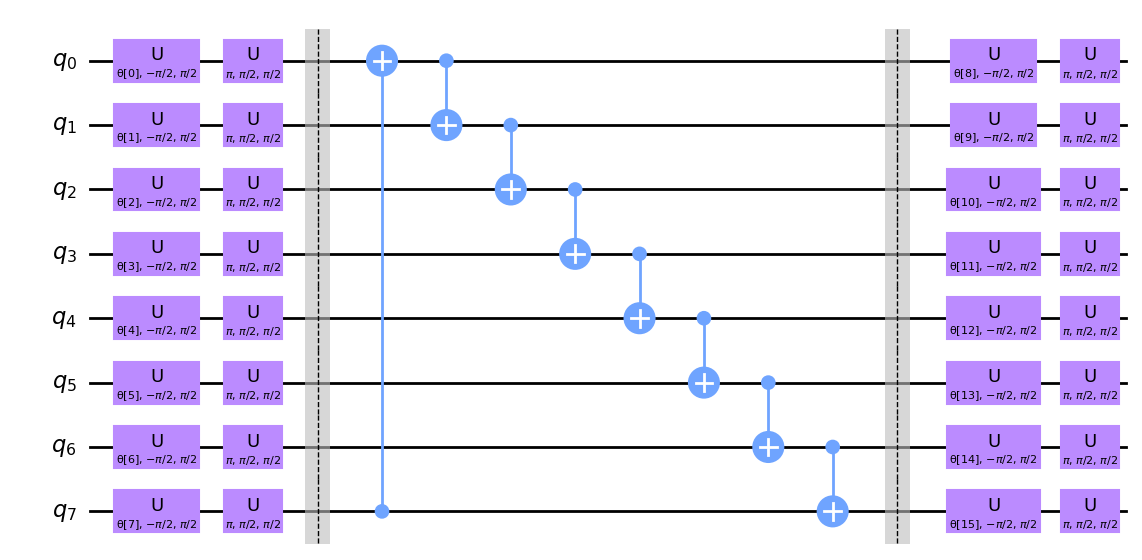

In [70]:
from qiskit.circuit.library import TwoLocal, EfficientSU2, RealAmplitudes, PauliTwoDesign, ExcitationPreserving

ansatz = EfficientSU2(H2_op.num_qubits, su2_gates=['rx', 'y'], entanglement='circular', reps=1, insert_barriers=True)

ansatz = ansatz.decompose(reps=2)
 
print(ansatz.count_ops())
print(ansatz.depth())
ansatz.decompose(reps=2).draw('mpl')

In [71]:
circuit = ansatz.decompose(reps=3)

# See how many parameters are in our ansatz
num_params = circuit.num_parameters

# List out the observables
observables_paulis = H2_op.paulis
observables = [str(i) for i in observables_paulis]

from circuit_knitting.cutting.gate_and_wire_cutting.frontend import cut_wires_and_gates_to_subcircuits

subcircuits, subobservables = cut_wires_and_gates_to_subcircuits(
    circuit=circuit,
    observables=observables,
    method='automatic',
    max_subcircuit_width=H2_op.num_qubits/2,
    max_cuts=4,
    num_subcircuits=[2],
    model='gurobi'
)

Set parameter TimeLimit to value 300
Set parameter Cutoff to value 1e+100
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (linux64)

CPU model: 11th Gen Intel(R) Core(TM) i7-11850H @ 2.50GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 201 rows, 103 columns and 622 nonzeros
Model fingerprint: 0x87c3f71d
Variable types: 0 continuous, 103 integer (80 binary)
Coefficient statistics:
  Matrix range     [1e-02, 2e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 2e+01]
  RHS range        [1e+00, 2e+00]
Presolve removed 49 rows and 36 columns
Presolve time: 0.00s
Presolved: 152 rows, 67 columns, 465 nonzeros
Variable types: 0 continuous, 67 integer (57 binary)
Found heuristic solution: objective 4.0000000
Found heuristic solution: objective 2.0000000

Root relaxation: cutoff, 49 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds   

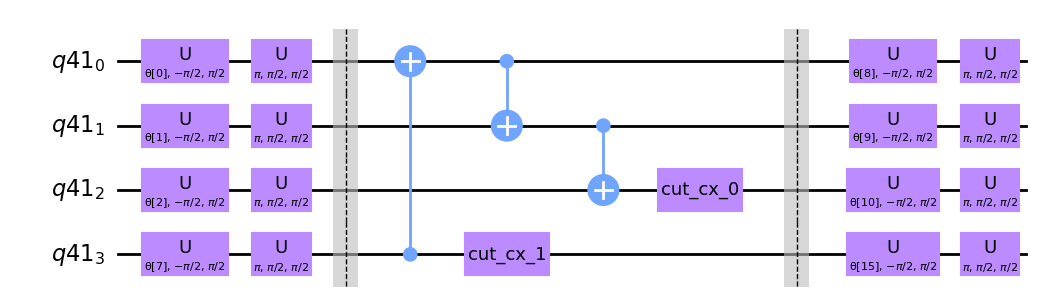

In [72]:
subcircuits[0].draw('mpl')

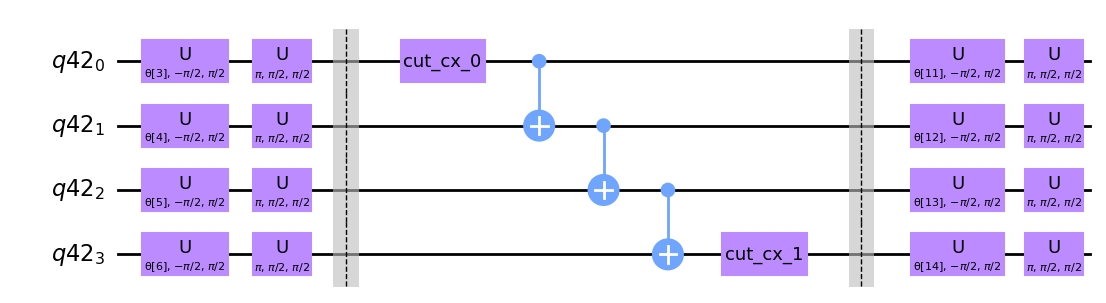

In [73]:
subcircuits[1].draw('mpl')

### 3. Get Energies for Cut Problem and Compare with Original (EfficientSU2)

In [74]:
# Use the modified CutVQE to cut and run VQE for our problem
estimator = Estimator()
optimizer = COBYLA(maxiter=80)
vqe = CutVQE(estimator, circuit, optimizer, observables=observables, shots=2**12, max_subcircuit_width=H2_op.num_qubits/2, max_cuts=9, num_subcircuits=[2], model='gurobi', num_samples=1500, callback=callback)
result = vqe.compute_minimum_eigenvalue(H2_op)
print(result)

Set parameter TimeLimit to value 300
Set parameter Cutoff to value 1e+100
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (linux64)

CPU model: 11th Gen Intel(R) Core(TM) i7-11850H @ 2.50GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 201 rows, 103 columns and 622 nonzeros
Model fingerprint: 0xf3ab342c
Variable types: 0 continuous, 103 integer (80 binary)
Coefficient statistics:
  Matrix range     [1e-02, 2e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 3e+01]
  RHS range        [1e+00, 2e+00]
Presolve removed 49 rows and 36 columns
Presolve time: 0.00s
Presolved: 152 rows, 67 columns, 465 nonzeros
Variable types: 0 continuous, 67 integer (57 binary)
Found heuristic solution: objective 4.0000000

Root relaxation: objective 1.142857e+00, 49 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  

Round num: 28, energy: -0.4033722894916052, parameters: [ 2.85363171 -2.76634211 -2.48880684  0.1630751   4.16896075 -4.98533838
 -1.27065916 -0.42602695 -6.47980258  6.09493374  2.99887944 -0.43616296
 -3.74831227  0.43300306  0.50099841 -0.89796979]
Round num: 29, energy: 0.1409266401248708, parameters: [ 2.81876396 -2.73644794 -2.22785735  0.0247737   4.12894054 -5.0383133
 -1.26361474 -0.43411752 -6.57889197  7.03590243  3.02897286 -0.44747255
 -3.75039157  0.39850247  0.56897576 -0.96165489]
Round num: 30, energy: -0.3297408771618236, parameters: [ 2.85363171 -2.76634211 -2.48880684  0.1630751   4.16896075 -4.98533838
 -0.89356738 -0.09769511 -6.47980258  6.09493374  2.99887944 -0.43616296
 -3.74831227  0.43300306  0.50099841 -0.89796979]
Round num: 31, energy: -0.4330347768880395, parameters: [ 2.83119882 -2.74710908 -2.52728063  0.07409603  4.14321292 -5.01942089
 -1.92707202  0.31297791 -6.54355379  6.04675973  3.01824067 -0.44343922
 -3.74965003  0.41080639  0.54473305 -0.9389

Round num: 61, energy: -0.8485961845912938, parameters: [ 3.0517067  -3.04121518 -2.84485685  0.09870343  4.40380821 -5.30155643
 -2.0653107   0.33984917 -6.19616016  6.3446965   2.90299827  0.13384869
 -4.33460769  0.36149749 -0.12486431 -0.90937304]
Round num: 62, energy: -0.8263249122830063, parameters: [ 3.05186837 -2.89096961 -2.80573806  0.03652508  4.38534252 -5.27123136
 -2.01686084  0.31909623 -6.33407398  6.37246829  2.92502696  0.05289041
 -4.41172126  0.44471148 -0.19801023 -0.8767578 ]
Round num: 63, energy: -0.8300529458892791, parameters: [ 3.07413374 -3.04428477 -2.83492283  0.15226435  4.24007474 -5.23792751
 -2.02157503  0.31402103 -6.4428515   6.26679399  2.92077914  0.04455011
 -4.38114507  0.4653267  -0.19205096 -0.88743303]
Round num: 64, energy: -0.7717323379822666, parameters: [ 3.03695488 -2.97490188 -2.79377416  0.07239806  4.32257394 -5.27416505
 -2.00475891  0.31980761 -6.32616109  6.3993082   2.95405312  0.16832461
 -4.45787254  0.44955821 -0.23305575 -0.88

In [75]:
# Do the same thing to compare againt not cutting at all
estimator = Estimator()
optimizer = COBYLA(maxiter=80)
no_cut_vqe = VQE(ansatz=circuit, optimizer=optimizer, estimator=estimator, callback=callback)
no_cut_result = no_cut_vqe.compute_minimum_eigenvalue(H2_op)
print(no_cut_result)

Round num: 1, energy: 1.0380117804347468, parameters: [-0.06142130629721798, 0.45258148007838983, -0.11097162345305556, -0.5919927600706076, -2.2274594855773735, 6.148553962863366, 2.55789973458249, 0.2664693693849802, -3.716521779856484, -0.4875243194616221, -1.9348932122904312, -2.763345790215995, -3.953734604857526, -0.49263742526803345, 2.5637624103105736, 0.7497854767672534]
Round num: 2, energy: 1.1821329260483318, parameters: [0.938578693702782, 0.45258148007838983, -0.11097162345305556, -0.5919927600706076, -2.2274594855773735, 6.148553962863366, 2.55789973458249, 0.2664693693849802, -3.716521779856484, -0.4875243194616221, -1.9348932122904312, -2.763345790215995, -3.953734604857526, -0.49263742526803345, 2.5637624103105736, 0.7497854767672534]
Round num: 3, energy: 1.0942633015370404, parameters: [-0.06142130629721798, 1.4525814800783898, -0.11097162345305556, -0.5919927600706076, -2.2274594855773735, 6.148553962863366, 2.55789973458249, 0.2664693693849802, -3.716521779856484,

Round num: 24, energy: -0.32917698524636924, parameters: [-0.20737309805089327, -0.18636455734814322, 0.28753392770504943, -0.14403323428747933, -2.731341554305215, 6.769391604432071, 3.6547229591178807, -0.10461627631037908, -3.7822235313038424, -0.513068113657072, -2.606785802641022, -1.3001182806269274, -2.8916868674684926, -0.5010124512980983, 3.6100945865682155, 0.2711749619178115]
Round num: 25, energy: -0.0693175481341254, parameters: [-0.5186679010633604, -0.4529917694693406, -0.30093740529418417, 0.12236731648661497, -3.082444989522369, 6.504355997262843, 3.693365015098301, -0.2527162013366214, -3.808445037245451, -0.5232626174033514, -2.2527075873030062, -1.1152446261591553, -2.866923675030411, -0.5043549161482846, 3.6285857136426714, 0.08016196481534779]
Round num: 26, energy: -0.004446624087508677, parameters: [-0.2073730980508933, -0.18636455734814322, 0.28753392770504943, -0.14403323428747933, -2.731341554305215, 6.769391604432071, 4.1385257758304155, 0.0216169781870693, 

Round num: 47, energy: -0.7402877649998719, parameters: [0.022140291002172338, 0.42951302523840107, -0.13743709273254584, -0.13185709009932217, -2.749952709972738, 6.279587560415691, 3.415380869563743, -0.2455428999480896, -3.949784859303688, -0.41887027864279863, -2.747620141021362, -0.7226847797385796, -2.733918046874345, -1.2370792005344868, 3.6089223312064256, -0.08731694856528585]
Round num: 48, energy: -0.6885539573737468, parameters: [-0.005104374798564071, 0.15496037581048552, 0.05498448358803197, -0.178768822370183, -2.6447116023065305, 6.086308058896115, 3.5451018245672254, -0.20566528336563694, -3.9368732866123084, -0.4456113748625721, -2.7173327825893456, -0.9966390808017049, -2.739265471202821, -1.238553902371314, 3.7816625727116238, -0.24087915576968083]
Round num: 49, energy: -0.7914068356490636, parameters: [0.0024090657122525228, 0.12785016385167983, -0.07446550880849993, -0.037429882251425045, -2.763750929985374, 5.9261502256971585, 3.8192959401585034, -0.105945818578

Round num: 69, energy: -1.0751267953869958, parameters: [-0.04347022084499147, -0.15590841481887158, -0.04299202067077315, 0.14412345734102613, -2.973884890346476, 5.880533763898259, 3.2945332512016865, 0.018959295869682646, -3.8894044744725305, -0.28647616216152794, -2.819853672607571, -0.5672193617061655, -2.8438295334056494, -1.2416358032172583, 3.7783688397437287, 0.007707758303123313]
Round num: 70, energy: -1.0929297472819672, parameters: [-0.032111852406873635, -0.155314203315844, -0.04123081350116565, 0.06612506167036156, -3.0333539621201426, 5.870023126537962, 3.2859082472566894, 0.0422698750671468, -3.901494286914444, -0.29487955489977763, -2.7944811742680438, -0.5759574544348373, -2.8856860409681895, -1.1954595485783193, 3.7733217175688107, 0.024952448480925718]
Round num: 71, energy: -1.1074758988390132, parameters: [-0.09457825932151825, -0.13851827149244456, -0.10502487702505023, 0.019657284249762125, -2.9123250352479397, 5.849712868368856, 3.243346866127587, 0.0321356708

In [76]:
print("CutVQE result:", result.optimal_value)
print("VQE result:", no_cut_result.optimal_value)

CutVQE result: -0.9079047242521896
VQE result: -1.2926066407064667


### 2. Create Ansatz and Cut (RealAmplitudes)

OrderedDict([('r', 16), ('cx', 7), ('barrier', 2)])
9


/home/vhazoglou/.local/lib/python3.10/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


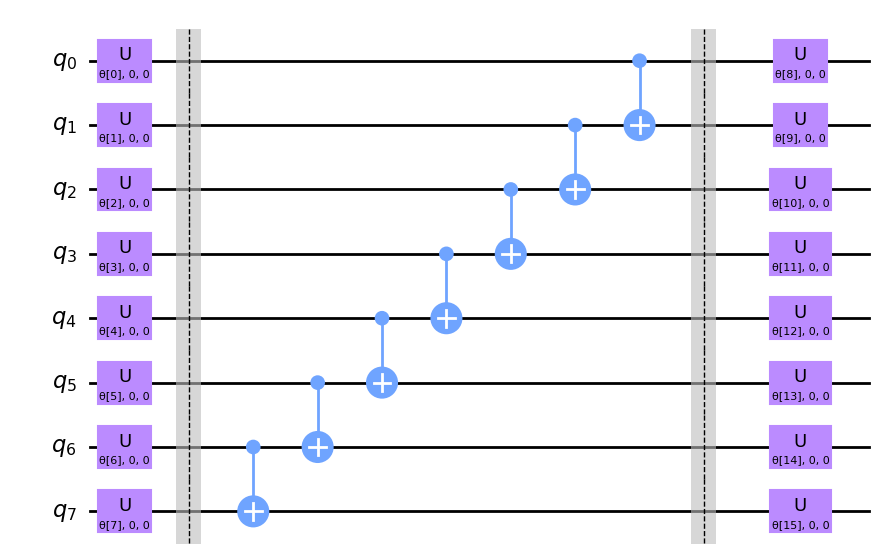

In [42]:
from qiskit.circuit.library import TwoLocal, EfficientSU2, RealAmplitudes, PauliTwoDesign, ExcitationPreserving

ansatz = RealAmplitudes(H2_op.num_qubits, reps=1, insert_barriers=True)
ansatz = ansatz.decompose(reps=2)
 
print(ansatz.count_ops())
print(ansatz.depth())
ansatz.decompose(reps=2).draw('mpl')

In [43]:
circuit = ansatz.decompose(reps=3)

# See how many parameters are in our ansatz
num_params = circuit.num_parameters

# List out the observables
observables_paulis = H2_op.paulis
observables = [str(i) for i in observables_paulis]

from circuit_knitting.cutting.gate_and_wire_cutting.frontend import cut_wires_and_gates_to_subcircuits

subcircuits, subobservables = cut_wires_and_gates_to_subcircuits(
    circuit=circuit,
    observables=observables,
    method='automatic',
    max_subcircuit_width=H2_op.num_qubits/2,
    max_cuts=4,
    num_subcircuits=[2],
    model='gurobi'
)

Set parameter TimeLimit to value 300
Set parameter Cutoff to value 1e+100
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (linux64)

CPU model: 11th Gen Intel(R) Core(TM) i7-11850H @ 2.50GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 175 rows, 93 columns and 530 nonzeros
Model fingerprint: 0x8051e698
Variable types: 0 continuous, 93 integer (70 binary)
Coefficient statistics:
  Matrix range     [1e-02, 2e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 2e+01]
  RHS range        [1e+00, 2e+00]
Presolve removed 57 rows and 40 columns
Presolve time: 0.00s
Presolved: 118 rows, 53 columns, 367 nonzeros
Variable types: 0 continuous, 53 integer (45 binary)
Found heuristic solution: objective 4.0000000
Found heuristic solution: objective 3.0000000
Found heuristic solution: objective 1.0000000

Root relaxation: cutoff, 38 iterations, 0.00 seconds (0.00 work units)

    Nodes    | 

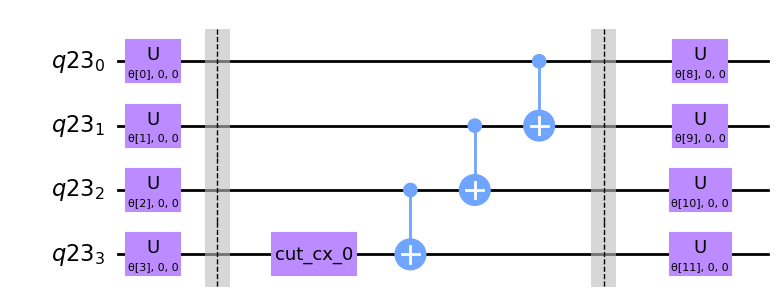

In [44]:
subcircuits[0].draw('mpl')

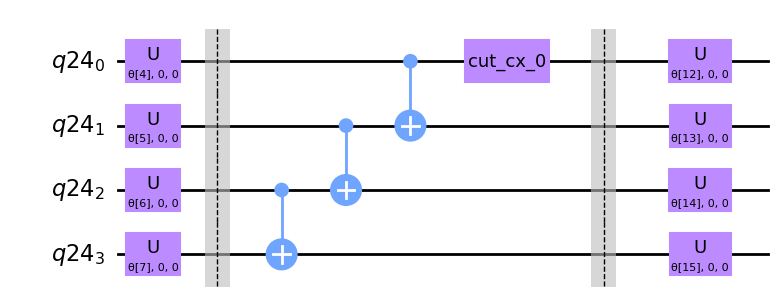

In [45]:
subcircuits[1].draw('mpl')

### 3. Get Energies for Cut Problem and Compare with Original (RealAmplitudes)

In [46]:
# Use the modified CutVQE to cut and run VQE for our problem
estimator = Estimator()
optimizer = COBYLA(maxiter=80)
vqe = CutVQE(estimator, circuit, optimizer, observables=observables, shots=2**12, max_subcircuit_width=H2_op.num_qubits/2, max_cuts=9, num_subcircuits=[2], model='gurobi', num_samples=1500, callback=callback)
result = vqe.compute_minimum_eigenvalue(H2_op)
print(result)

Set parameter TimeLimit to value 300
Set parameter Cutoff to value 1e+100
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (linux64)

CPU model: 11th Gen Intel(R) Core(TM) i7-11850H @ 2.50GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 175 rows, 93 columns and 530 nonzeros
Model fingerprint: 0x0d826f2d
Variable types: 0 continuous, 93 integer (70 binary)
Coefficient statistics:
  Matrix range     [1e-02, 2e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 3e+01]
  RHS range        [1e+00, 2e+00]
Presolve removed 57 rows and 40 columns
Presolve time: 0.00s
Presolved: 118 rows, 53 columns, 367 nonzeros
Variable types: 0 continuous, 53 integer (45 binary)
Found heuristic solution: objective 4.0000000
Found heuristic solution: objective 1.0000000

Root relaxation: cutoff, 42 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds     

Round num: 28, energy: 0.19646352185675334, parameters: [ 1.97895617 -0.78501652  1.76724222  4.81673008  5.10092277  2.67686407
  4.33595341  1.01006716  7.27544175  7.34118625 -5.69672917  4.44847381
 -4.36735099  5.47316836  0.58868371 -3.6736407 ]
Round num: 29, energy: -0.05897136183510873, parameters: [ 2.14668503 -0.72034492  1.71616414  4.7044841   5.08003639  2.56910375
  4.22288736  1.19834672  7.27229082  6.4053281  -5.06149008  4.64216852
 -4.43672812  5.56468857  0.76403538 -3.64699764]
Round num: 30, energy: -0.1573793949253036, parameters: [ 1.97895617 -0.78501652  1.76724222  4.81673008  5.10092277  2.67686407
  4.33595341  1.01006716  7.27544175  6.86138215 -5.83739908  4.27987366
 -4.83806746  5.47316836  0.58868371 -3.6736407 ]
Round num: 31, energy: -0.3149651527053606, parameters: [ 2.24616799 -0.68198706  1.68586883  4.63790903  5.0676483   2.50518919
  4.15582588  1.31001866  7.27042196  6.58653091 -6.14195439  3.61722912
 -4.7043959   5.61897083  0.86803955 -3.6

Round num: 61, energy: -0.6118606386902371, parameters: [ 2.4673043  -0.47539414  1.84085834  4.25748558  5.02326585  2.17899302
  3.77712344  1.78679656  7.1612775   6.60118295 -6.34216713  3.62579237
 -4.81870464  5.32993928  0.08074364 -3.69628877]
Round num: 62, energy: -0.6197528271423884, parameters: [ 2.4686493  -0.49349144  1.93852972  4.35426653  4.98157665  2.15723077
  3.68982172  1.87716023  7.18887308  6.53915862 -6.41971946  3.6132226
 -4.88434568  5.36948559  0.11428555 -3.7828165 ]
Round num: 63, energy: -0.574020218464129, parameters: [ 2.45215954 -0.54684389  1.93544786  4.35277882  4.99079834  2.05518742
  3.69302771  1.86932035  7.20318888  6.5243177  -6.3900781   3.63278472
 -4.88974628  5.37891606  0.11673214 -3.77210674]
Round num: 64, energy: -0.5201069380359318, parameters: [ 2.53286364 -0.55764571  1.98135725  4.24989446  4.96509963  2.26364893
  3.69211758  1.84174494  7.23522113  6.50796528 -6.40153199  3.47036276
 -4.9389357   5.38534137  0.1167519  -3.8225

In [47]:
# Do the same thing to compare againt not cutting at all
estimator = Estimator()
optimizer = COBYLA(maxiter=80)
no_cut_vqe = VQE(ansatz=circuit, optimizer=optimizer, estimator=estimator, callback=callback)
no_cut_result = no_cut_vqe.compute_minimum_eigenvalue(H2_op)
print(no_cut_result)

Round num: 1, energy: 3.464220712820538, parameters: [-4.35475408456729, -1.0887593316605084, -4.758148559140599, -2.0617725238042413, 3.4335052753875264, -0.4003021769090518, -5.599094034625055, -0.7663931613394928, 4.106301309012736, 1.5975504095212454, 5.443534927229779, -1.108950050350468, -4.507022761551248, 5.528177534842964, -2.8089339521407095, 4.105586751976663]
Round num: 2, energy: 3.5635588152180224, parameters: [-3.35475408456729, -1.0887593316605084, -4.758148559140599, -2.0617725238042413, 3.4335052753875264, -0.4003021769090518, -5.599094034625055, -0.7663931613394928, 4.106301309012736, 1.5975504095212454, 5.443534927229779, -1.108950050350468, -4.507022761551248, 5.528177534842964, -2.8089339521407095, 4.105586751976663]
Round num: 3, energy: 3.4401596778511743, parameters: [-4.35475408456729, -0.08875933166050842, -4.758148559140599, -2.0617725238042413, 3.4335052753875264, -0.4003021769090518, -5.599094034625055, -0.7663931613394928, 4.106301309012736, 1.59755040952

Round num: 45, energy: -0.8739314870009348, parameters: [-3.3605310495754197, 0.2842511273626301, -6.761734898207683, 0.49152113375304324, 6.552897044191582, -1.2190807517773583, -3.7101941374659, 1.9528584686505999, 3.50107630766385, 3.2488186724112804, 6.322196029144911, 0.36080209967817883, -3.226376017481456, 6.767272349040788, -1.370315873855362, 4.788431859017166]
Round num: 46, energy: -1.1363053048468663, parameters: [-3.4792747878850845, 0.3110964527825182, -6.5783724167340925, 0.10769768913223678, 6.102316284217805, -1.5013317123912397, -3.7297529798050113, 1.7523191237921367, 3.5628046108740388, 3.1053768263276464, 5.971340561294376, 0.05483428009577962, -3.7137391136492126, 6.349525275168569, -1.4124239056034524, 5.064184482845594]
Round num: 47, energy: -0.8937816602107914, parameters: [-3.704361381536208, 0.6901593525674394, -6.270615702959405, -0.2282151399138273, 6.620502759741909, -1.2597902515843884, -3.9419579830314957, 1.852513381413479, 3.5975407679709295, 3.126801

Round num: 69, energy: -1.292308367339015, parameters: [-3.6067132004854034, -0.21881948015811992, -6.34503522199789, -0.10333449839054223, 5.896603905188965, -1.984688940482321, -3.8097756256881072, 1.4626066387768089, 3.7487614125240327, 2.5866235949763814, 6.018519472676456, 0.22306645391191465, -3.386397467388328, 6.22506588314126, -0.8375686270295126, 4.667236633021286]
Round num: 70, energy: -1.2617306486118995, parameters: [-3.6012912821769754, -0.20242946616909438, -6.3704332674142385, -0.03418673490199453, 5.876750586605868, -2.0756968167679, -3.6671298828762904, 1.4832807716597676, 3.838508955966925, 2.5956094340079705, 5.972462548221193, -0.08433279802417412, -3.5409399498426444, 6.218009134803688, -0.9563509444636208, 5.03402043591578]
Round num: 71, energy: -1.2640013462591901, parameters: [-3.511720975779049, -0.38508999754244927, -6.506878178206148, 0.10529728979511838, 6.021305385894543, -2.084023151431299, -3.7439066271241397, 1.6122027129548187, 3.8750848739814794, 2.

In [48]:
print("CutVQE result:", result.optimal_value)
print("VQE result:", no_cut_result.optimal_value)

CutVQE result: -0.6197528271423884
VQE result: -1.3405896353446265


### 2. Create Ansatz and Cut (TwoLocal)

OrderedDict([('r', 16), ('cx', 14), ('u3', 14), ('u1', 7), ('barrier', 2)])
31


/home/vhazoglou/.local/lib/python3.10/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


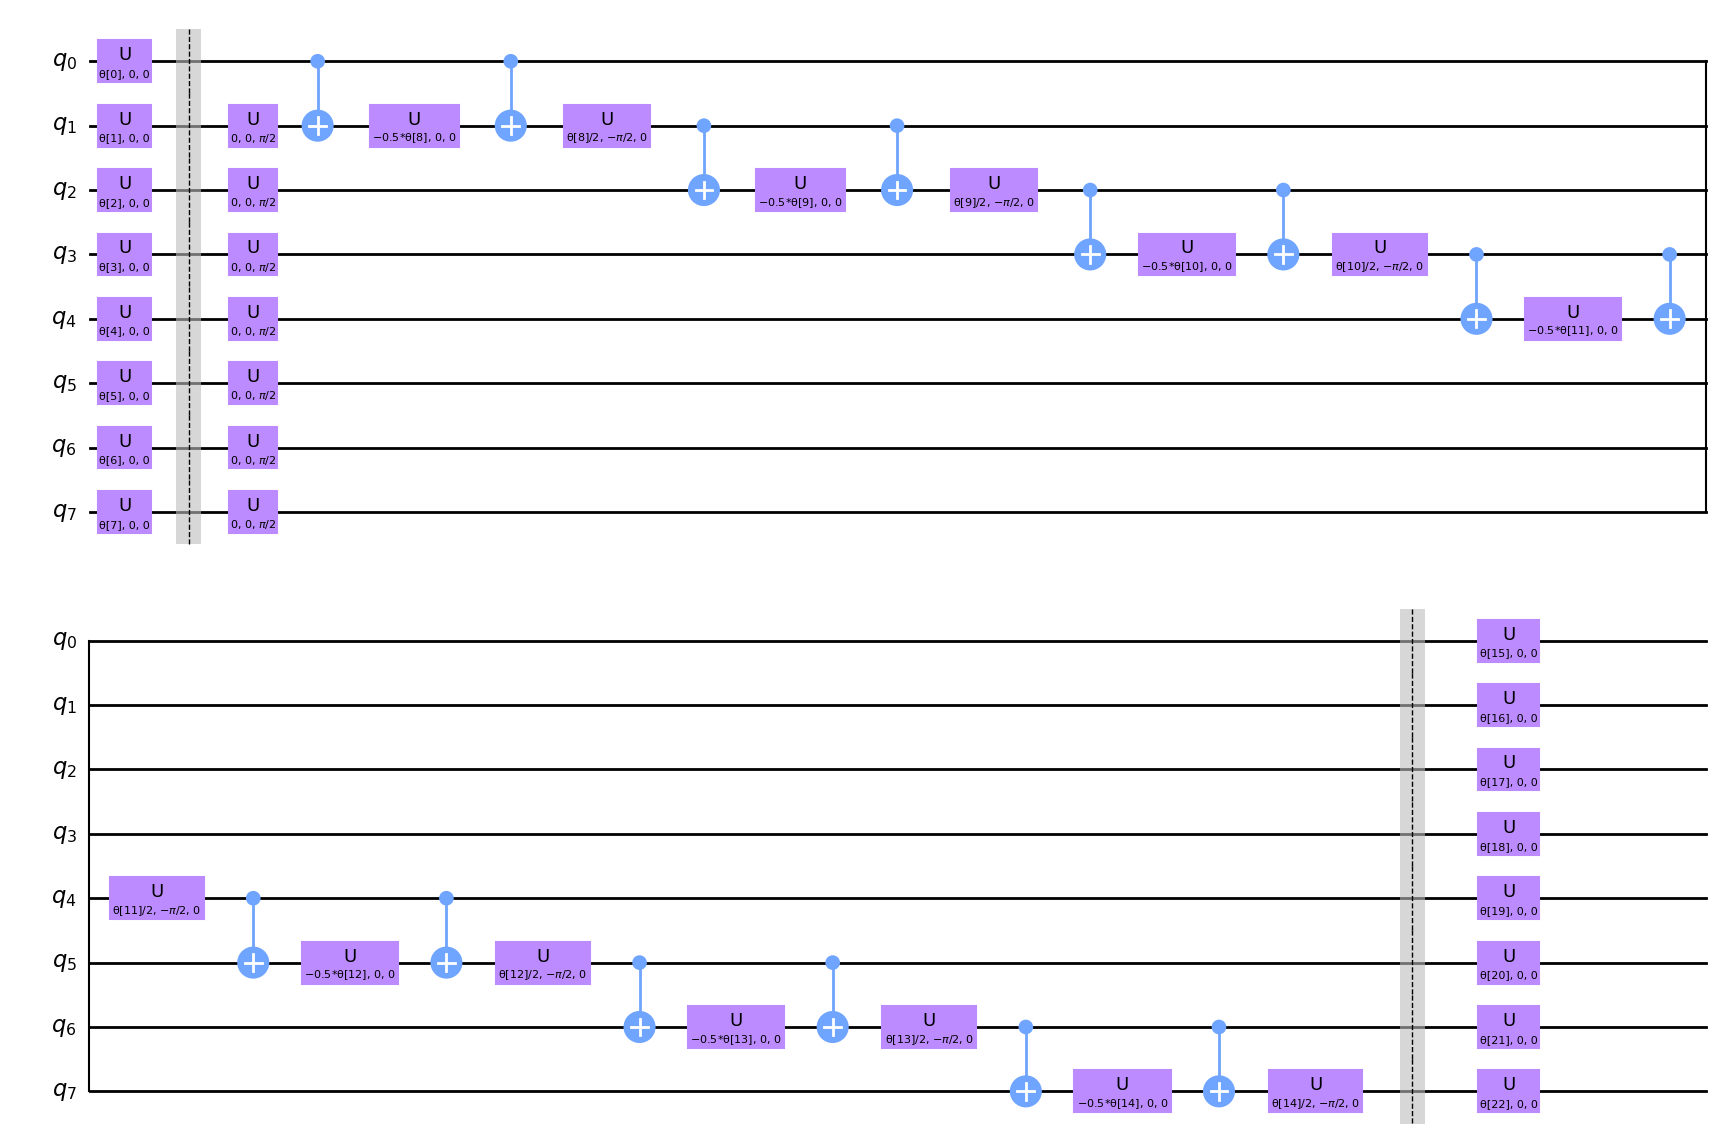

In [60]:
from qiskit.circuit.library import TwoLocal, EfficientSU2, RealAmplitudes, PauliTwoDesign, ExcitationPreserving

ansatz = TwoLocal(H2_op.num_qubits, 'ry', 'crx', 'linear', reps=1, insert_barriers=True)
ansatz = ansatz.decompose(reps=2)
 
print(ansatz.count_ops())
print(ansatz.depth())
ansatz.decompose(reps=2).draw('mpl')

In [61]:
circuit = ansatz.decompose(reps=3)

# See how many parameters are in our ansatz
num_params = circuit.num_parameters

# List out the observables
observables_paulis = H2_op.paulis
observables = [str(i) for i in observables_paulis]

from circuit_knitting.cutting.gate_and_wire_cutting.frontend import cut_wires_and_gates_to_subcircuits

subcircuits, subobservables = cut_wires_and_gates_to_subcircuits(
    circuit=circuit,
    observables=observables,
    method='automatic',
    max_subcircuit_width=H2_op.num_qubits/2,
    max_cuts=4,
    num_subcircuits=[2],
    model='gurobi'
)

Set parameter TimeLimit to value 300
Set parameter Cutoff to value 1e+100
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (linux64)

CPU model: 11th Gen Intel(R) Core(TM) i7-11850H @ 2.50GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 357 rows, 163 columns and 1174 nonzeros
Model fingerprint: 0xe56adc0c
Variable types: 0 continuous, 163 integer (140 binary)
Coefficient statistics:
  Matrix range     [1e-02, 2e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 2e+01]
  RHS range        [1e+00, 2e+00]
Presolve removed 61 rows and 48 columns
Presolve time: 0.00s
Presolved: 296 rows, 115 columns, 939 nonzeros
Variable types: 0 continuous, 115 integer (105 binary)
Found heuristic solution: objective 4.0000000
Found heuristic solution: objective 2.0000000

Root relaxation: infeasible, 111 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective

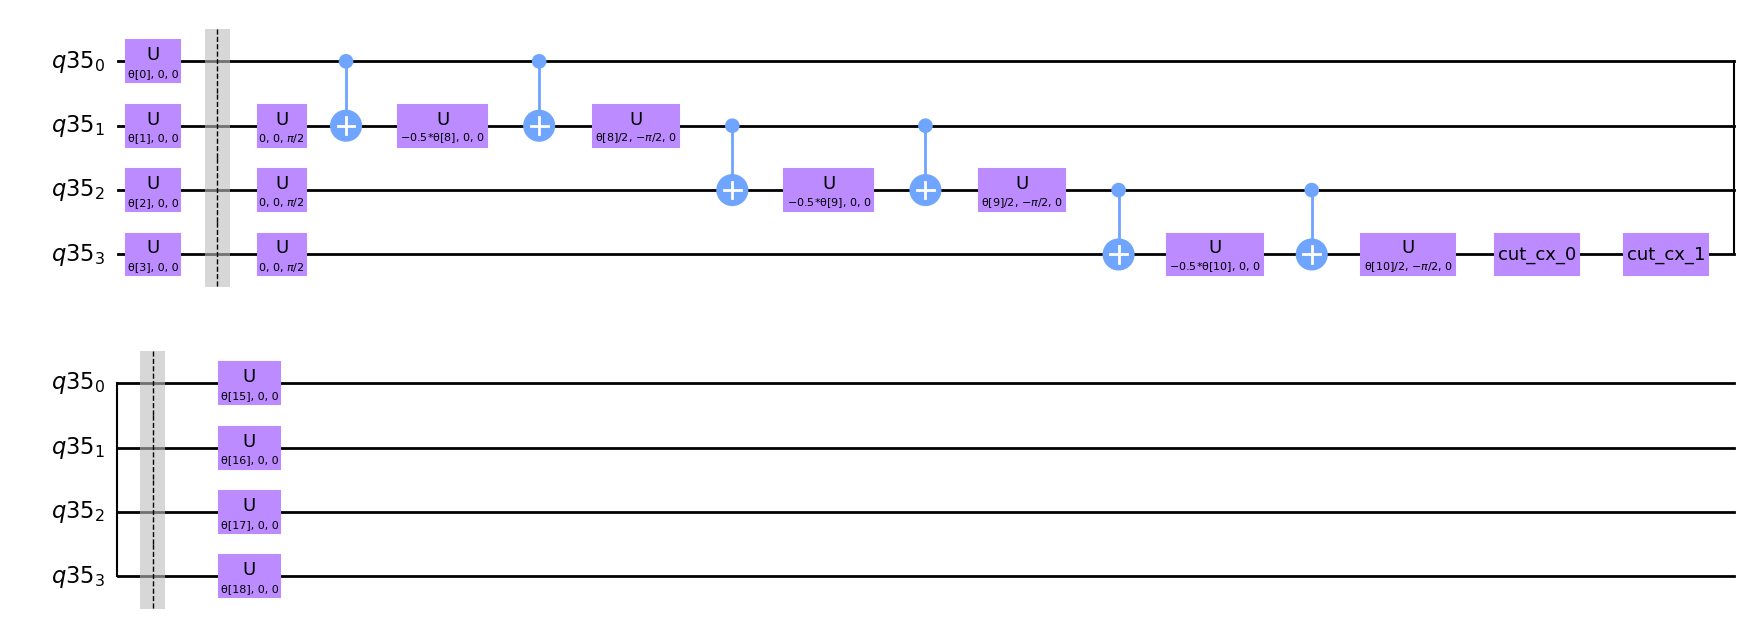

In [62]:
subcircuits[0].draw('mpl')

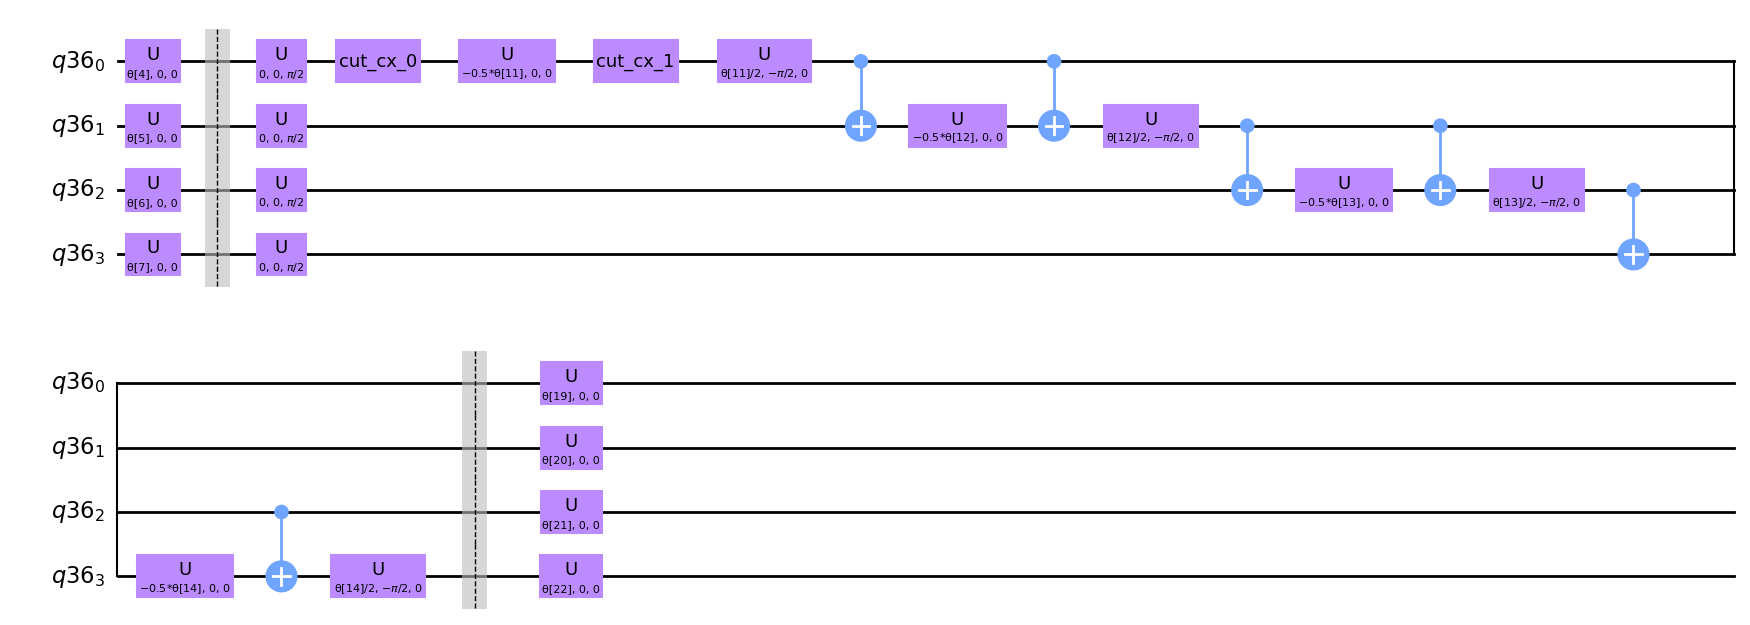

In [63]:
subcircuits[1].draw('mpl')

### 3. Get Energies for Cut Problem and Compare with Original (TwoLocal)

In [64]:
# Use the modified CutVQE to cut and run VQE for our problem
estimator = Estimator()
optimizer = COBYLA(maxiter=80)
vqe = CutVQE(estimator, circuit, optimizer, observables=observables, shots=2**12, max_subcircuit_width=H2_op.num_qubits/2, max_cuts=9, num_subcircuits=[2], model='gurobi', num_samples=1500, callback=callback)
result = vqe.compute_minimum_eigenvalue(H2_op)
print(result)

Set parameter TimeLimit to value 300
Set parameter Cutoff to value 1e+100
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (linux64)

CPU model: 11th Gen Intel(R) Core(TM) i7-11850H @ 2.50GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 357 rows, 163 columns and 1174 nonzeros
Model fingerprint: 0xf72111e4
Variable types: 0 continuous, 163 integer (140 binary)
Coefficient statistics:
  Matrix range     [1e-02, 2e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 3e+01]
  RHS range        [1e+00, 2e+00]
Presolve removed 61 rows and 48 columns
Presolve time: 0.00s
Presolved: 296 rows, 115 columns, 939 nonzeros
Variable types: 0 continuous, 115 integer (105 binary)
Found heuristic solution: objective 6.0000000
Found heuristic solution: objective 4.0000000
Found heuristic solution: objective 2.0000000

Root relaxation: infeasible, 111 iterations, 0.00 seconds (0.00 work units)

   

Round num: 21, energy: -0.6283959015015437, parameters: [ 1.68285617  2.6611299  -2.83519524 -4.49332024  1.45055549 -4.13876502
  2.06239113 -5.31302751 -1.48767103 -1.40688916 -1.08213479  7.02603747
  3.1219513   6.56631565  1.50521197 -1.29825047  0.1212991  -3.43173945
 -2.46699828 -1.76355076  5.00776581  3.74231512  5.08749845]
Round num: 22, energy: -0.48754347586093155, parameters: [ 1.68285617  2.6611299  -2.83519524 -4.49332024  1.45055549 -4.13876502
  2.06239113 -5.31302751 -1.48767103 -1.40688916 -1.08213479  7.02603747
  3.1219513   6.56631565  1.50521197 -1.29825047  0.1212991  -3.43173945
 -2.46699828 -2.76355076  6.00776581  3.74231512  5.08749845]
Round num: 23, energy: -0.2710056658975764, parameters: [ 1.68285617  2.6611299  -2.83519524 -4.49332024  1.45055549 -4.13876502
  2.06239113 -5.31302751 -1.48767103 -1.40688916 -1.08213479  7.02603747
  3.1219513   6.56631565  1.50521197 -1.29825047  0.1212991  -3.43173945
 -2.46699828 -2.76355076  5.00776581  4.74231512  

Round num: 46, energy: -0.9783552568952876, parameters: [ 1.02038186  3.19517824 -3.43661336 -4.61365527  1.42488988 -4.24837524
  2.33165002 -5.44619879 -1.78573006 -1.60384099 -1.73601997  6.41613652
  3.65032732  6.80726849  1.25097724 -0.95224536  0.21493967 -3.83059986
 -2.39796042 -2.78262065  4.79474194  4.39620652  4.3889404 ]
Round num: 47, energy: -1.1128813866163485, parameters: [ 0.90591864  3.07215062 -3.24513229 -4.4681446   1.3666871  -4.26610604
  2.38567497 -5.20349405 -1.99816663 -1.31521958 -1.49296158  6.77947795
  3.39001227  6.60084094  1.21875173 -1.01031682  0.63494788 -3.82615375
 -2.42577041 -2.77493887  5.0817601   3.79095729  4.58418285]
Round num: 48, energy: -1.0472475126824388, parameters: [ 0.91812739  3.13645004 -3.30509018 -4.52207889  1.37268354 -4.26229731
  2.4000802  -5.19815251 -2.02634442 -1.32014732 -1.57839588  6.75978704
  3.43129633  6.61728945  1.14919034 -0.92388242 -0.219259   -3.85208364
 -2.41706235 -2.77734424  5.77180301  3.75225571  4

Round num: 71, energy: -1.0819155637503592, parameters: [ 0.97269979  3.02253024 -3.24892575 -4.45509419  1.41386112 -4.28103735
  2.31986125 -5.43980145 -2.0198515  -1.41870386 -1.47780859  7.03878654
  3.26716207  6.82081946  1.27118389 -0.88675588  0.14428673 -3.7004769
 -2.8965391  -2.78461582  4.86929271  3.73029792  4.52716074]
Round num: 72, energy: -1.1129456145567151, parameters: [ 0.98025557  3.05036837 -3.23745242 -4.50376137  1.41061004 -4.29065004
  2.31050474 -5.20211279 -2.00835612 -1.35748532 -1.49048802  6.71781942
  3.43689453  6.61306069  1.23694347 -0.9673482   0.26878241 -3.80731467
 -3.05592891 -2.69298171  4.98792203  3.79714132  4.57533886]
Round num: 73, energy: -1.1280241714552985, parameters: [ 0.88447049  3.11442133 -3.25971501 -4.48991121  1.35551106 -4.27250896
  2.4160124  -5.19816147 -1.99116715 -1.31261087 -1.52337641  6.79494368
  3.37970868  6.60511728  1.19459045 -0.98146947  0.19563276 -3.82336445
 -2.95052294 -2.7755239   4.8813963   3.80698639  4.

In [65]:
# Do the same thing to compare againt not cutting at all
estimator = Estimator()
optimizer = COBYLA(maxiter=80)
no_cut_vqe = VQE(ansatz=circuit, optimizer=optimizer, estimator=estimator, callback=callback)
no_cut_result = no_cut_vqe.compute_minimum_eigenvalue(H2_op)
print(no_cut_result)

Round num: 1, energy: 0.8897716501232582, parameters: [-0.9431063298100248, 0.8968836812996015, 3.0317446946071698, -1.8597605824804155, 3.3704386200958574, 3.2726297136850953, 3.260601406595672, -4.485661117547108, 5.2267183132751835, 4.811339601378652, 0.474628074037291, 5.82297374371327, -5.215886600725956, -2.0593934821009006, 0.6009314179617231, -4.604747431289522, 6.28021812415245, 5.894199070833958, -2.546256949172169, 3.2442269500129797, -3.4546134655136513, 0.7936623519903643, -5.9583187818394805]
Round num: 2, energy: 0.8789394029404453, parameters: [0.056893670189975154, 0.8968836812996015, 3.0317446946071698, -1.8597605824804155, 3.3704386200958574, 3.2726297136850953, 3.260601406595672, -4.485661117547108, 5.2267183132751835, 4.811339601378652, 0.474628074037291, 5.82297374371327, -5.215886600725956, -2.0593934821009006, 0.6009314179617231, -4.604747431289522, 6.28021812415245, 5.894199070833958, -2.546256949172169, 3.2442269500129797, -3.4546134655136513, 0.79366235199036

Round num: 20, energy: 0.4308833394064197, parameters: [0.056893670189975154, 0.8968836812996015, 3.0317446946071698, -1.8597605824804155, 4.370438620095857, 3.2726297136850953, 4.260601406595672, -4.485661117547108, 5.2267183132751835, 4.811339601378652, 0.474628074037291, 6.82297374371327, -5.215886600725956, -2.0593934821009006, 1.6009314179617231, -4.604747431289522, 7.28021812415245, 6.894199070833958, -1.546256949172169, 3.2442269500129797, -3.4546134655136513, 0.7936623519903643, -5.9583187818394805]
Round num: 21, energy: 0.4516872784755538, parameters: [0.056893670189975154, 0.8968836812996015, 3.0317446946071698, -1.8597605824804155, 4.370438620095857, 3.2726297136850953, 4.260601406595672, -4.485661117547108, 5.2267183132751835, 4.811339601378652, 0.474628074037291, 6.82297374371327, -5.215886600725956, -2.0593934821009006, 1.6009314179617231, -4.604747431289522, 7.28021812415245, 6.894199070833958, -1.546256949172169, 4.24422695001298, -3.4546134655136513, 0.793662351990364

Round num: 43, energy: -0.6883609361798554, parameters: [-0.14042639648030555, 1.4985553899730262, 3.3112273619024433, -0.01880632903343144, 4.829155722053434, 3.9778618591349053, 3.7196798817272936, -4.738724870667233, 5.2252670630730895, 4.763622948064503, -0.3908469306937057, 6.962300415806743, -5.099945254428373, -1.7390633231229005, 1.7584029409096773, -3.8034456270768175, 7.404749689056993, 6.476388511486189, -0.5275126570518237, 3.131926596264736, -2.2630244342490395, 2.301486490745336, -7.90195936008117]
Round num: 44, energy: -0.04159736597856782, parameters: [-0.18123506236126474, 1.67670208715381, 3.452921022743729, 0.26863073200943943, 4.860447662231413, 3.9834261117068217, 3.757696056419938, -4.9195739676477155, 5.229894176688182, 4.74084012409839, -0.5703116523657776, 7.094155686172798, -5.023635925481764, -1.6484858887341354, 1.9227680903086313, -3.7355042608854037, 7.523522306325261, 7.036753975466206, -1.2937388287292602, 3.1077658309229133, -2.2218051729381756, 2.4107

Round num: 67, energy: -1.1781785568325298, parameters: [-0.7357947193584363, 1.853460611925521, 4.108512165055762, 0.4767148637112002, 4.841277515952219, 4.389177308755741, 3.628611036787002, -4.941454272652079, 5.322043770409212, 4.710483772712374, 0.21673087588372966, 7.013001687911572, -4.883690344750325, -1.4700748894678244, 1.7966733898037655, -3.983985144718293, 7.3051069847390275, 7.486272693545738, 0.18871904403366882, 3.232711216824026, -2.498636329297189, 2.1010261770778715, -7.687800158804298]
Round num: 68, energy: -1.1046555342762232, parameters: [-0.7450233829643461, 1.8761905362478064, 4.197745597047479, 0.4904029379338608, 4.839324226321982, 4.402253712642838, 3.6126968019807353, -4.979396412391107, 5.46961521215844, 4.6989828565046885, 0.2692506326509322, 6.73224991768323, -4.8706056609679775, -1.4438731173854678, 1.8930419028326053, -3.9867601357537215, 7.196230510766641, 7.187994002331428, 0.19599951542972122, 3.373089728365755, -2.538238888471306, 2.106757008688658

In [66]:
print("CutVQE result:", result.optimal_value)
print("VQE result:", no_cut_result.optimal_value)

CutVQE result: -1.176402476925968
VQE result: -1.3867476280150102


### 4 - Note: ExcitationPreserving Ansatz is being skipped as it produces *very* deep circuits.

OrderedDict([('r', 20), ('h', 14), ('cx', 7), ('u1', 4), ('barrier', 2)])
8


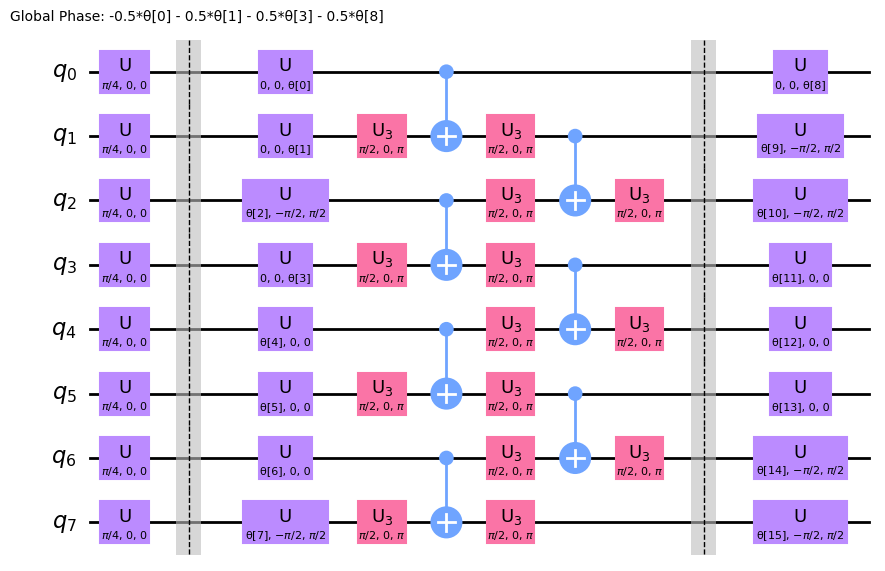

In [9]:
from qiskit.circuit.library import TwoLocal, EfficientSU2, RealAmplitudes, PauliTwoDesign, ExcitationPreserving

ansatz = PauliTwoDesign(H2_op.num_qubits, reps=1, seed=5, insert_barriers=True)

#ansatz = ExcitationPreserving(H2_op.num_qubits, reps=1, insert_barriers=True, entanglement='linear')
ansatz = ansatz.decompose(reps=2)
 
print(ansatz.count_ops())
print(ansatz.depth())
ansatz.decompose(reps=2).draw('mpl')

In [18]:
circuit = ansatz.decompose(reps=3)

# See how many parameters are in our ansatz
num_params = circuit.num_parameters

# List out the observables
observables_paulis = H2_op.paulis
observables = [str(i) for i in observables_paulis]

from circuit_knitting.cutting.gate_and_wire_cutting.frontend import cut_wires_and_gates_to_subcircuits

subcircuits, subobservables = cut_wires_and_gates_to_subcircuits(
    circuit=circuit,
    observables=observables,
    method='automatic',
    max_subcircuit_width=H2_op.num_qubits/2,
    max_cuts=4,
    num_subcircuits=[4],
    model='gurobi'
)

Set parameter TimeLimit to value 300
Set parameter Cutoff to value 1e+100
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (linux64)

CPU model: 11th Gen Intel(R) Core(TM) i7-11850H @ 2.50GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 331 rows, 183 columns and 1055 nonzeros
Model fingerprint: 0xa2153fec
Variable types: 0 continuous, 183 integer (140 binary)
Coefficient statistics:
  Matrix range     [1e-02, 2e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 2e+01]
  RHS range        [1e+00, 2e+00]
Presolve removed 73 rows and 44 columns
Presolve time: 0.00s
Presolved: 258 rows, 139 columns, 764 nonzeros
Variable types: 0 continuous, 139 integer (113 binary)
Found heuristic solution: objective 4.0000000

Root relaxation: objective 6.161616e-01, 150 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unex

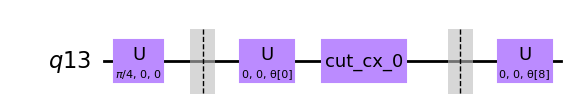

In [19]:
subcircuits[0].draw('mpl')

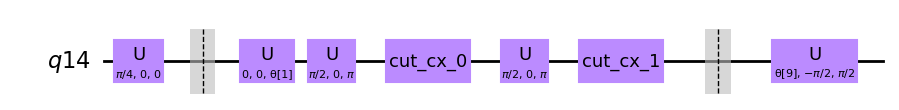

In [20]:
subcircuits[1].draw('mpl')

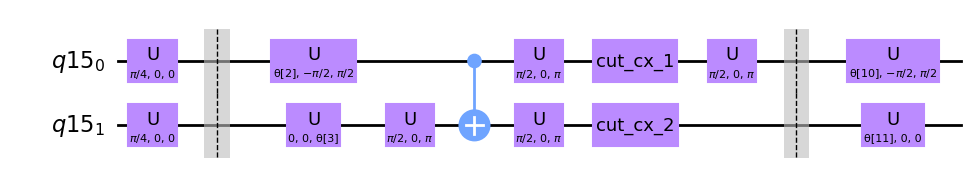

In [21]:
subcircuits[2].draw('mpl')

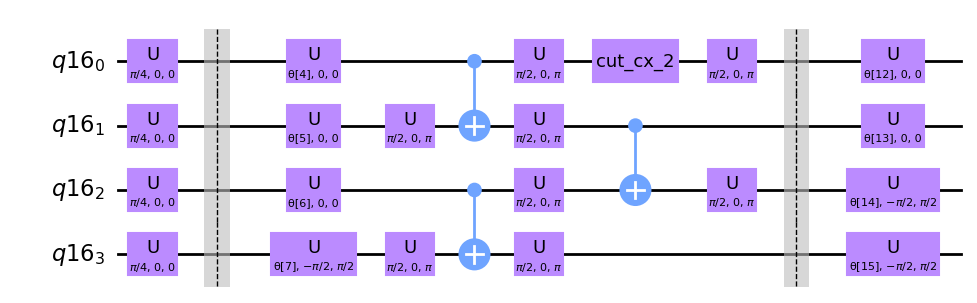

In [22]:
subcircuits[3].draw('mpl')